# Firebase

In [7]:
import firebase_admin
from dotenv import load_dotenv
from firebase_admin import credentials, firestore
from google.cloud.firestore_v1 import Client, CollectionReference

load_dotenv()

try:
    cred = credentials.ApplicationDefault()
    firebase_admin.initialize_app()
except:
    pass

firestore_client: Client = firestore.client()


In [8]:
limit = 1000
tracks_ref = firestore_client.collection(u'tracks')

offset = 0
completed = False

track_data = []

while not completed:
    docs = tracks_ref\
        .offset(offset)\
        .limit(limit)\
        .stream()
    current_track_data = [doc.to_dict() for doc in docs]
    completed = len(current_track_data) == 0
    track_data += current_track_data
    offset += limit


In [9]:
import pandas as pd

df = pd.DataFrame(track_data)
df.set_index("id", inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3861 entries, 005lwxGU1tms6HGELIcUv9 to 7zkLpY72g6lKQbiHDqri1S
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3780 non-null   float64
 1   tags              3702 non-null   object 
 2   duration          3861 non-null   int64  
 3   liveness          3780 non-null   float64
 4   valence           3780 non-null   float64
 5   artist_genres     3861 non-null   object 
 6   mode              3780 non-null   float64
 7   danceability      3780 non-null   float64
 8   artist_names      3861 non-null   object 
 9   name              3861 non-null   object 
 10  tempo             3780 non-null   float64
 11  pitches           3691 non-null   object 
 12  loudness          3780 non-null   float64
 13  energy            3780 non-null   float64
 14  acousticness      3780 non-null   float64
 15  instrumentalness  3780 non-null   float64
 16  time_sig

In [11]:
df = df[~df["pitches"].isna()]

In [12]:
tolower = lambda s: s.lower()
flatmap = lambda list_of_lists: [item for l in list_of_lists for item in l]
tags = pd.Series(flatmap(df[~df["tags"].isna()]["tags"].values.tolist())).apply(tolower).drop_duplicates()
tags.info()

<class 'pandas.core.series.Series'>
Int64Index: 23465 entries, 0 to 130220
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
23465 non-null  object
dtypes: object(1)
memory usage: 366.6+ KB


In [13]:
tags

0         i killed a bird and i lyked it
1                          dancing songs
2                        guilty pleasure
3                               girl pop
4                            alternative
                       ...              
129971                          odisseus
129972                       roddy ricch
129976                   headnodic beats
129996                          math pop
130220                         soft jazz
Length: 23465, dtype: object

In [14]:
pitch_symbol = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]


def pitch_trans(p):
    pitch_frequency = list()
    for timestamp in p:
        pitch_dict = {"timestamp": float(timestamp)}
        for i in range(0, len(p[timestamp])):
            pitch_dict[pitch_symbol[i]] = p[timestamp][i]
        pitch_frequency.append(pitch_dict)
    return pitch_frequency


def pitches_to_dataframe(p):
    return pd.DataFrame(p).sort_values(by=["timestamp"])


pitches = df["pitches"].apply(pitch_trans)
df["pitches"] = pitches

In [15]:
df["pitches"]

id
005lwxGU1tms6HGELIcUv9    [{'timestamp': 43.0102, 'C': 0.179, 'C#': 0.22...
00B7TZ0Xawar6NZ00JFomN    [{'timestamp': 86.38444, 'C': 0.499, 'C#': 0.3...
00GOPLxW4PGQuUYdPJh8K1    [{'timestamp': 135.7409, 'C': 0.278, 'C#': 1.0...
00Mb3DuaIH1kjrwOku9CGU    [{'timestamp': 192.5688, 'C': 0.723, 'C#': 0.1...
00R0fEFZGb5hyTgF1nrRCq    [{'timestamp': 81.83637, 'C': 0.135, 'C#': 0.0...
                                                ...                        
7zMcNqs55Mxer82bvZFkpg    [{'timestamp': 26.80739, 'C': 0.178, 'C#': 0.3...
7zQcq1UIdlplwkoTuJcU1r    [{'timestamp': 88.74023, 'C': 0.226, 'C#': 0.0...
7zRmGvtSy36Jr19U5OInJT    [{'timestamp': 111.93692, 'C': 0.152, 'C#': 0....
7zSbZj5aalmS4yYLOLwDd6    [{'timestamp': 28.25859, 'C': 0.999, 'C#': 0.7...
7zkLpY72g6lKQbiHDqri1S    [{'timestamp': 142.61592, 'C': 0.359, 'C#': 0....
Name: pitches, Length: 3691, dtype: object

In [16]:
first_song = pitches_to_dataframe(pitches.iloc[0])
first_song

,timestamp,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
425,0.00000,0.368,0.063,0.053,0.029,0.032,0.061,0.080,0.047,0.058,0.058,0.054,1.000
203,0.10603,0.379,0.321,0.166,0.095,0.662,1.000,0.297,0.079,0.056,0.061,0.048,0.441
194,0.41156,0.055,0.177,0.129,0.124,0.165,0.195,1.000,0.971,0.213,0.174,0.113,0.131
24,0.53859,0.091,0.071,0.406,1.000,0.514,0.401,0.123,0.109,0.138,0.057,0.048,0.057
171,0.87243,0.541,0.345,0.226,0.384,0.362,0.352,1.000,0.861,0.173,0.197,0.260,0.157
...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,175.93161,0.515,0.409,0.128,0.510,0.477,1.000,0.758,0.214,0.159,0.230,0.244,0.301
452,176.12321,0.341,0.226,0.190,0.395,0.745,1.000,0.705,0.263,0.155,0.184,0.144,0.210
241,176.32082,0.794,0.480,0.342,0.492,1.000,0.321,0.138,0.171,0.174,0.162,0.178,0.986
414,176.65211,0.219,0.230,0.268,0.419,1.000,0.305,0.464,0.486,0.262,0.275,0.087,0.201


<AxesSubplot: xlabel='timestamp'>

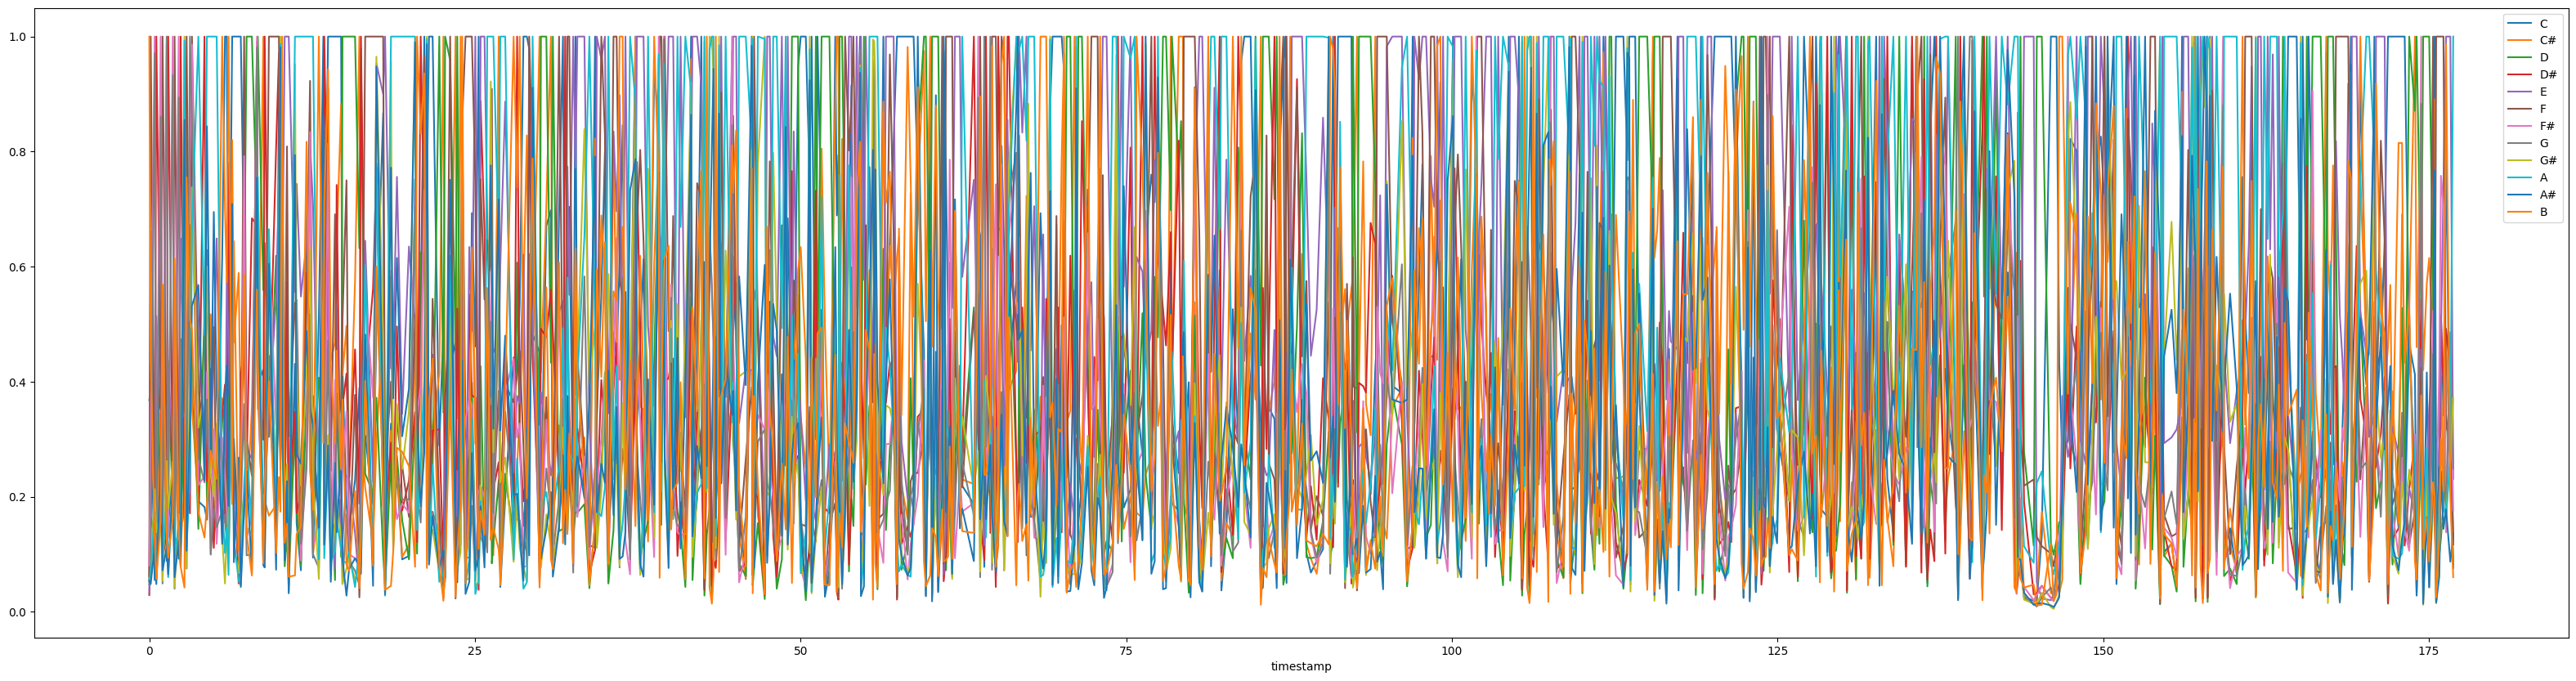

In [17]:
first_song.plot(x="timestamp", figsize=(40, 10))

In [18]:
from typing import List

from typing import Dict


def max_of_pitches(freq: List[Dict[str, float]], pitch: chr):
    return max([item[pitch] for item in freq])


def min_of_pitches(freq: List[Dict[str, float]], pitch: chr):
    return min([item[pitch] for item in freq])


for sym in pitch_symbol:
    df.insert(len(df.columns), f"{sym}_max", [max_of_pitches(item, sym) for item in df["pitches"]])
    df.insert(len(df.columns), f"{sym}_min", [min_of_pitches(item, sym) for item in df["pitches"]])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3691 entries, 005lwxGU1tms6HGELIcUv9 to 7zkLpY72g6lKQbiHDqri1S
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3691 non-null   float64
 1   tags              3620 non-null   object 
 2   duration          3691 non-null   int64  
 3   liveness          3691 non-null   float64
 4   valence           3691 non-null   float64
 5   artist_genres     3691 non-null   object 
 6   mode              3691 non-null   float64
 7   danceability      3691 non-null   float64
 8   artist_names      3691 non-null   object 
 9   name              3691 non-null   object 
 10  tempo             3691 non-null   float64
 11  pitches           3691 non-null   object 
 12  loudness          3691 non-null   float64
 13  energy            3691 non-null   float64
 14  acousticness      3691 non-null   float64
 15  instrumentalness  3691 non-null   float64
 16  time_sig

In [19]:
temp_df = pd.DataFrame()

for index, row in enumerate(df["pitches"].values):
    song = pitches_to_dataframe(row)
    song["timestamp"] = song["timestamp"].apply(pd.to_timedelta, unit='s')
    resampled: pd.DataFrame = song.set_index("timestamp")\
             .resample(f"{song.iloc[-1]['timestamp'].total_seconds() * 10 // 1}ms")\
             .mean()\
             .interpolate()[:100]
    d: pd.DataFrame = pd.DataFrame()
    for col in resampled.columns:
        if col == "timestamp":
            continue
        d = pd.concat([d, pd.DataFrame({f"{col}_{row_idx}" : [val] for row_idx, val in enumerate(resampled[col].values)}, index=[df.index[index]])], axis=1)
    temp_df = pd.concat([temp_df, d])

df = pd.concat([df, temp_df], axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3691 entries, 005lwxGU1tms6HGELIcUv9 to 7zkLpY72g6lKQbiHDqri1S
Columns: 1241 entries, key to B_99
dtypes: float64(1235), int64(1), object(5)
memory usage: 35.1+ MB


In [20]:
df.drop(columns=["pitches"], inplace=True)
df.to_csv("songs.csv")